In [1]:
import os
import pandas as pd
import numpy as np

np.random.seed(30224)

import emoji
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora.dictionary import Dictionary
import gensim.matutils
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import re
import json
from sklearn.preprocessing import MinMaxScaler
import math
from statsmodels.tsa.stattools import grangercausalitytests
from statsmodels.tsa.stattools import adfuller

/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/matplotlib/__init__.py:152: DeprecationWarnin

In [2]:
# 1 Data selection
# 1.1 Data Sourcing

"""
ETHUSD_min.cvs is high-frequency exchange price data for Ethereum/USD (ETH/USD) from Oct 1st, 2023 to Nov 30th.
The ETH/USD data  were collected at 1-min intervals.
"""


def plot_price_dynamics(df):
    df.resample("D").Close.last().plot(kind="line")
    plt.title("ETH/USD Price Dynamics/Day")
    plt.xlabel("Time")
    plt.ylabel("Price")
    # xlabel too long, rotate it
    plt.xticks(rotation=45)
    plt.show()

    # Plot the number of posts and comments per minute
    df.head(60).resample("1T").Close.last().plot(kind="line")
    plt.title("ETH/USD Price Dynamics/Minute")
    plt.xlabel("Time")
    plt.ylabel("Price")
    # xlabel too long, rotate it
    plt.xticks(rotation=45)
    plt.show()


# load ETHUSD_min.cvs from data folder and convert the time column to datetime format
def load_price_data(file_path):
    price_raw = pd.read_csv(file_path)
    df = price_raw[["Time", "Close"]].copy()
    df["Time"] = pd.to_datetime(df["Time"])
    df.set_index("Time", inplace=True)
    df.head()
    df.to_pickle("df.pkl")
    # plot price dynamics
    plot_price_dynamics(df)

    return df

In [3]:
"""
r_ethtrader_comments.jsonl is the comment data from the Reddit community r/ethtrader.
"""


def load_post_data(file_path="data/r_ethtrader_posts_trimmed.jsonl"):
    # load r_ethtrader_posts.jsonl from data folder
    posts_raw = pd.read_json(file_path, lines=True)

    # Keep meta data about text that informs how much the
    # community engaged with the post (upvote ratio, score, total awards recieved , total number of comments)
    meta_cols = [
        "upvote_ratio",
        "score",
        "total_awards_received",
        "num_comments",
        "created",
        # "selftext_flair",
        # "title_flair",
        "id",
    ]
    text_cols = ["selftext", "title"]
    # Drop the rest of the features
    posts = posts_raw[text_cols + meta_cols]
    # load r_ethtrader_comments.jsonl from data folder
    comments_raw = pd.read_json(
        "data/r_ethtrader_comments_trimmed.jsonl", lines=True
    )
    # comments has no selftext and title columns, instead it is "body" column. use it as selftext_new
    comments = comments_raw[
        ["body"] + [c for c in meta_cols if c in comments_raw.columns]
        ].copy()
    comments.rename(columns={"body": "selftext"}, inplace=True)
    comments["title"] = ""
    # combine posts and comments into one dataframe
    posts = pd.concat([posts, comments], ignore_index=True)

    posts.info()
    posts.head()
    posts[posts.selftext == "[removed]"].shape
    posts[posts.title == "[removed]"].shape
    # find all the posts that its title has [str] in it
    # posts[posts.title.str.contains("\[.*\]")].shape
    # extract these [str] values from the title and put them in a new column called title flair
    # posts["title_flair"] = posts.title.str.extract("(\[.*\])", expand=False)
    posts["title_flair"] = posts.title.str.extract("(\[[^\]]+\])", expand=False)
    posts["title_flair"].value_counts()
    # extract these [str] values from the selftext and put them in a new column called selftext flair
    # posts["selftext_flair"] = posts.selftext.str.extract("(\[.*\])", expand=False)
    posts["selftext_flair"] = posts.selftext.str.extract(
        "(\[[^\]]+\])", expand=False
    )
    posts["selftext_flair"].value_counts().head(30)
    #  converting 'created' timestamp to human readable date time (YYYY-MM-DD HH-MM-SS)
    posts["created"] = pd.to_datetime(posts["created"], unit="s")
    # Replace [removed] in selftext with empty string
    posts["selftext"].replace("[removed]", "", inplace=True)
    # Combine post title and selftext as new selftext.
    posts["selftext_new"] = posts["title"] + " " + posts["selftext"]
    posts["selftext_new_flair"] = posts.selftext_new.str.extract(
        "(\[[^\]]+\])", expand=False
    )
    # remove all flair from selftext_new
    # posts["selftext_new"] = posts["selftext_new"].str.replace("\[[^\]]+\]", " ")
    return posts

<>:47: DeprecationWarning: invalid escape sequence \[
<>:52: DeprecationWarning: invalid escape sequence \[
<>:62: DeprecationWarning: invalid escape sequence \[
<>:47: DeprecationWarning: invalid escape sequence \[
<>:52: DeprecationWarning: invalid escape sequence \[
<>:62: DeprecationWarning: invalid escape sequence \[
<ipython-input-3-6a23025d7fcd>:47: DeprecationWarning: invalid escape sequence \[
  posts["title_flair"] = posts.title.str.extract("(\[[^\]]+\])", expand=False)
<ipython-input-3-6a23025d7fcd>:52: DeprecationWarning: invalid escape sequence \[
  "(\[[^\]]+\])", expand=False
<ipython-input-3-6a23025d7fcd>:62: DeprecationWarning: invalid escape sequence \[
  "(\[[^\]]+\])", expand=False


In [4]:
# extract emojis from selftext_new
def extract_text_emojis(text):
    encode = emoji.UNICODE_EMOJI["en"]
    emojis = {char: encode[char] for char in text if char in encode}
    return ",".join(emojis.keys()), ",".join(emojis.values())


def extract_post_emojis(posts):
    posts[["emojis", "emoji_texts"]] = (
        posts["selftext_new"].apply(extract_text_emojis).apply(pd.Series)
    )
    # display the top 30 emojis and their text
    posts["emojis"].str.split(",", expand=True).stack().value_counts().head(30)
    posts["emoji_texts"].str.split(",", expand=True).stack().value_counts().head(30)
    # convert a set of emojis to a string so that it can be used in sentiment analysis later
    emoji_to_keep_dict = {
        ":rocket:": "emojirocket",
        ":flexed_biceps:": "emojiflexedbiceps",
        ":loudly_crying_face:": "emojiloudlycryingface",
        ":person_facepalming:": "emojipersonfacepalming",
    }
    # if the emoji is not in the emoji_to_keep_dict, replace it with empty string
    posts["emoji_texts_selected"] = posts["emoji_texts"].apply(
        lambda x: " ".join([emoji_to_keep_dict.get(i, "") for i in x.split(",")])
    )

    return posts

In [5]:
# Step 1: Preprocess the Data
# only keep letters.
# only word more than {word_len} letters longs
# lower case all words
# remove stop words
# stem words, not used as word cloud is better with full words
def tidy_text(text, minimum_word_len):
    # only keep letters.
    text_tidy = re.sub("[^a-zA-Z]", " ", text)
    # lower case word and remove short words and space
    text_tidy_token = [
        w.lower()
        for w in text_tidy.split()
        if len(w) > minimum_word_len and w != " "
    ]
    return word_detokenize(text_tidy_token)


def word_tokenize(text):
    return text.split()


def word_detokenize(text):
    return " ".join(text)


stop_words = stopwords.words("english")
# add new stop words into the list
custom_stop_words = ["https", "http", "www", "com", "png", "gif", "reddit", "img"]
# new_stop_words = []
stop_words += custom_stop_words


def remove_stop_words(text):
    # (d) Removing stopwords
    tokens = word_tokenize(text)
    return word_detokenize([word for word in tokens if word not in stop_words])


# stemmer = PorterStemmer()
# def stemming(tokens):
#     # (e) Stemming
#     tokens = [stemmer.stem(word) for word in tokens]
#     return " ".join(tokens)
stem_dict = {
    "ethereum": "eth",
}


def stemming(tokens):
    # (e) Stemming
    tokens = [stem_dict.get(word, word) for word in tokens]
    return " ".join(tokens)

In [6]:
def preprocess_post(posts):
    # extract emojis from selftext_new before preprocessing
    posts = extract_post_emojis(posts)

    minimum_word_len = 2
    minimum_post_len = 10
    # only keep letters and minimum 2 letters long
    posts["selftext_tidy"] = posts["selftext_new"].apply(
        lambda x: tidy_text(x, minimum_word_len)
    )
    # remove stop words
    posts["selftext_no_stop_word"] = posts["selftext_tidy"].apply(remove_stop_words)

    # add selected emoji texts back to the content as TEXT
    posts["selftext_no_stop_word"] = (
            posts["selftext_no_stop_word"] + " " + posts["emoji_texts_selected"]
    )
    # stem words
    posts["selftext_stemmed"] = posts["selftext_no_stop_word"].apply(stemming)
    # only posts with more than 10 characters
    posts = posts[posts.selftext_no_stop_word.str.len() > minimum_post_len]

    return posts

In [7]:
# Using LDA classify the posts into x number of topics. The number of LDA modeling topics is determined in such a way that the topic coherence score was maximized.
# select the column that will be used for LDA, and convert it back to a string
def train_lda_classification(
        posts,
        text_column="selftext_no_stop_word",
        recalculate_optimal_topics=True,
        topic_range=range(2, 10),
):
    """

    :param posts:
    :param text_column: to select the column that will be used for LDA. if use tidy text, use "selftext_tidy" and selftext_tokenized.
            if use stemmed text, use "selftext_stemmed" and need to tokenize  selftext_stemmed to selftext_tokenized
    :return:
    """
    posts["preprocessed_selftext"] = posts[text_column]
    posts["preprocessed_selftext_tokenized"] = posts[text_column].apply(
        word_tokenize
    )

    # Step 2: Vectorize the Text
    # Define text processing functions
    # vectorizer = CountVectorizer()
    vectorizer = TfidfVectorizer()
    selftext_vectorized = vectorizer.fit_transform(posts["preprocessed_selftext"])
    # get the bag of words
    vocabulary = vectorizer.get_feature_names_out()
    vocabulary[:20]

    # perform LDA and Coherence Score analysis. Find the optimal number of topics base on choherence score
    # identity key sentiment lexicon on the topics,

    # Step 3: Choose a Range for the Number of Topics
    corpus = gensim.matutils.Sparse2Corpus(
        selftext_vectorized, documents_columns=False
    )
    id2word = dict((id, word) for word, id in vectorizer.vocabulary_.items())
    dictionary = Dictionary.from_corpus(corpus, id2word=id2word)
    if recalculate_optimal_topics:
        # Step 4: Train LDA Models and Calculate Coherence Scores
        coherence_scores = []

        for num_topics in topic_range:
            lda_model = LdaModel(
                corpus=corpus,
                num_topics=num_topics,
                id2word=dictionary,
            )
            coherence_model = CoherenceModel(
                model=lda_model,
                texts=posts["preprocessed_selftext_tokenized"],
                dictionary=lda_model.id2word,
                coherence="c_v",
            )
            coherence_scores.append(coherence_model.get_coherence())

        # Step 5: Select the Model with the Highest Coherence Score
        optimal_topics = topic_range[
            coherence_scores.index(np.nanmax(coherence_scores))
        ]
        print(optimal_topics)
        print("optimal topics:", optimal_topics)
    else:
        optimal_topics = 2

    # use the optimal number of topics to train the final LDA model
    # Step 6: Final LDA Model
    final_lda_model = LdaModel(
        corpus=corpus,
        num_topics=optimal_topics,
        id2word=dictionary,
    )
    return final_lda_model, corpus, vectorizer, optimal_topics


# Classify the Posts
def classify_post(post_text, vectorizer, final_lda_model):
    # Step 1: Preprocess the Post (ensure this is consistent with your initial preprocessing)

    # Step 2: Vectorize the Post
    post_vectorized = vectorizer.transform([post_text])

    # Step 3: Use LDA Model to Classify the Post
    post_corpus = gensim.matutils.Sparse2Corpus(
        post_vectorized, documents_columns=False
    )

    # Convert to readable format
    post_lda_distribution = list(final_lda_model.get_document_topics(post_corpus))
    topics = [
        final_lda_model.show_topic(topic[0]) for topic in post_lda_distribution[0]
    ]
    return topics


def plot_topics_word_ranking(final_lda_model, corpus, topn=30):
    # `final_lda_model` is the trained LDA model
    # And `corpus` is the corpus used for LDA training

    # Step 1: Extract Topic Terms and Their Probabilities
    for topic_id in range(final_lda_model.num_topics):
        top_words = final_lda_model.show_topic(topic_id, topn=topn)
        print(f"Topic {topic_id}:")
        for term, probability in top_words:
            print(f"    {term} ({probability})")

    # Step 2: Interpreting Each Topic
    # This step involves looking at the words and determining a theme for each topic


def pyLDAvis_display(final_lda_model, corpus):
    # Step 3: Visualizing the Results
    # Prepare visualization
    lda_display = gensimvis.prepare(
        final_lda_model, corpus=corpus, dictionary=final_lda_model.id2word
    )

    # Display visualization in Jupyter Notebook (or save as HTML)
    pyLDAvis.display(lda_display)

In [8]:
# display word cloud of each topics

# `final_lda_model` is the trained LDA model

def plot_word_cloud(lda_model, topic_id, ax, topn=20):
    # Extract word probabilities for the topic
    word_probs = {
        word: prob for word, prob in lda_model.show_topic(topic_id, topn=topn)
    }

    # Generate word cloud
    wordcloud = WordCloud(width=400, height=400, background_color="white")
    wordcloud.generate_from_frequencies(word_probs)

    # Display the word cloud using matplotlib
    ax.imshow(wordcloud, interpolation="bilinear")
    ax.set_title("Topic " + str(topic_id))
    ax.axis("off")


def plot_topics_word_cloud(final_lda_model, optimal_topics):
    # Plotting word clouds for each topic
    minimum_rows = math.ceil(optimal_topics / 2)
    fig, axs = plt.subplots(
        minimum_rows, 2, figsize=(20, 20)
    )  # Adjust the layout and size as needed
    for i, ax in enumerate(axs.flatten()):
        if i < final_lda_model.num_topics:
            plot_word_cloud(final_lda_model, i, ax)
        else:
            ax.axis("off")

    plt.tight_layout()
    plt.show()

In [9]:
# Use Valence Aware Dictionary and Sentiment Reasoner (VADER) sentiment package to assess the sentiment of selftext from posts\_text dataframe

def add_sentiment(analyzer, posts):
    """
    The SentimentIntensityAnalyser object from the VADER package 1 was used to extract the polarity_scores. polar-
    ity_scores provide the overall sentiment metrics (compound score) for the comments. The compound score was
    computed by taking the sum of the valence scores of each word in the lexicon, adjusted according to the five gen-
    eral rules defined by Hutto and Gilbert (2014), and then normalized to be between −1 (most negative) and +1 (most
    positive). When the compound score is greater than 0.05, it denotes a positive sentiment. When the compound score
    is less than −0.05, it denotes a negative sentiment. A compound score between 0.05 and −0.05 denotes a neutral
    sentiment.

    In addition to the compound score, VADER SentimentIntensityAnalyser also returns Positive, Negative, and
    Neutral scores for a text. These scores were calculated as the sum of Positive, Negative, and Neutral valence scores in
    the lexicon, respectively.
    """
    #  Apply Sentiment Analysis to Each Post
    # The sentiment scores store in the 'sentiment' column of the DataFrame
    posts["sentiment"] = posts["preprocessed_selftext"].apply(
        analyzer.polarity_scores
    )
    # Step 5: create new NET column
    # The sentiment scores has compound, negative, neutral, and positive scores.
    # we can use the compound score to determine the sentiment of the post.

    # I will create a new NET_sentiment column that is the difference between the positive and negative measures
    posts["NET_sentiment"] = posts["sentiment"].apply(lambda x: x["pos"] - x["neg"])
    return posts

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 328823 entries, 0 to 328822
Data columns (total 8 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   selftext               328823 non-null  object 
 1   title                  328823 non-null  object 
 2   upvote_ratio           4506 non-null    float64
 3   score                  328823 non-null  int64  
 4   total_awards_received  328823 non-null  int64  
 5   num_comments           4506 non-null    float64
 6   created                328823 non-null  int64  
 7   id                     328823 non-null  object 
dtypes: float64(2), int64(3), object(3)
memory usage: 20.1+ MB


/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or tex

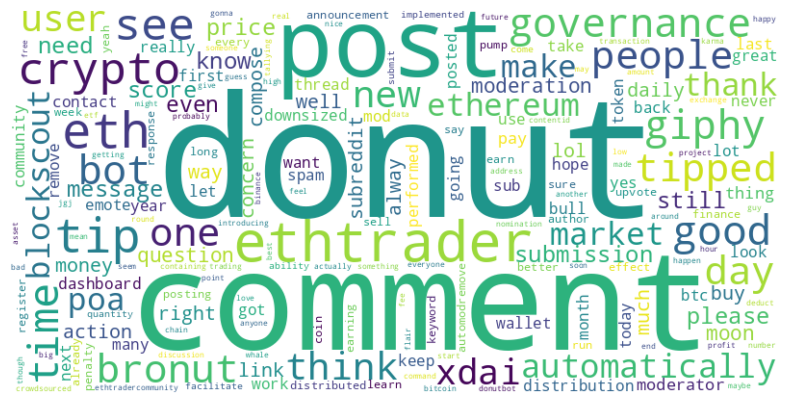

posts.pkl is up to date


/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or textlength instead.
  box_size = draw.textsize(word, font=transposed_font)
/home/joe/anaconda3/envs/myenv/lib/python3.8/site-packages/wordcloud/wordcloud.py:501: DeprecationWarning: textsize is deprecated and will be removed in Pillow 10 (2023-07-01). Use textbbox or tex

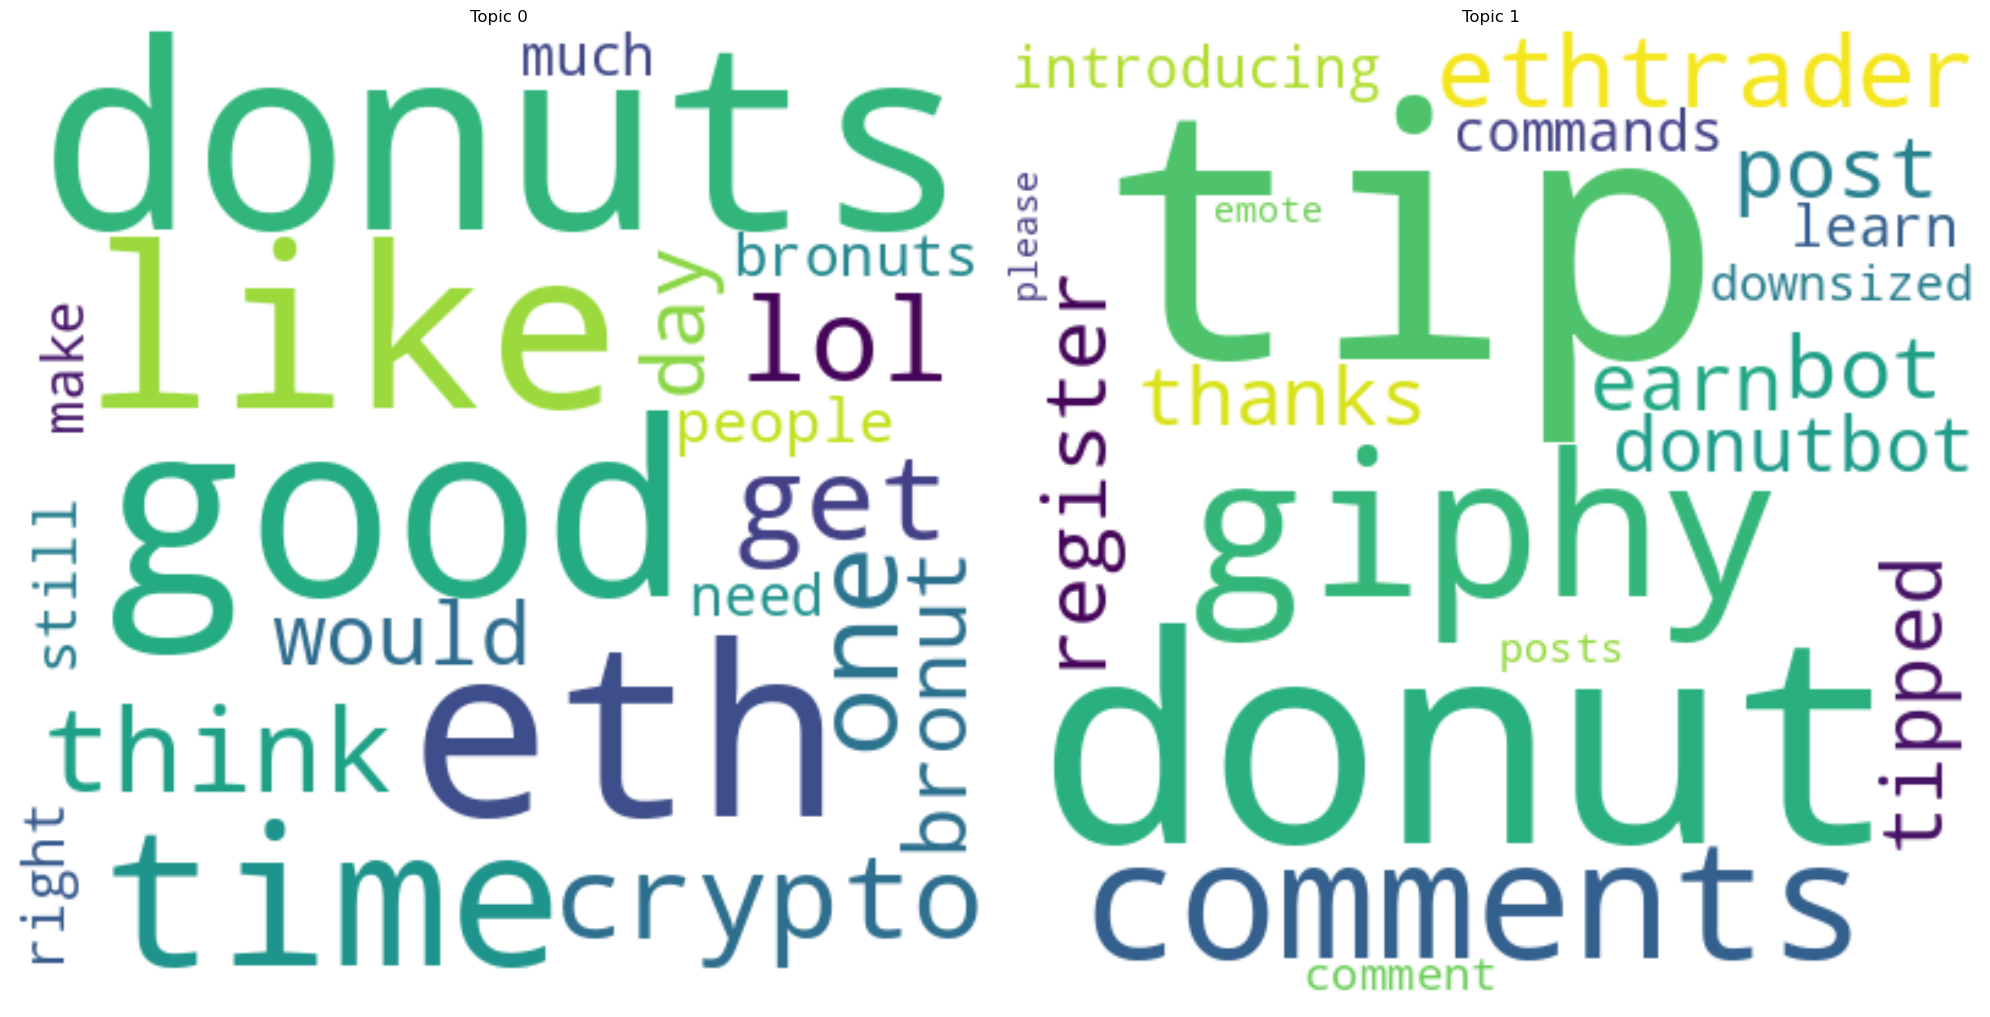

Topic 0:
    donuts (0.007924988865852356)
    good (0.006984534207731485)
    eth (0.006761680357158184)
    like (0.0059998659417033195)
    time (0.005086939316242933)
    crypto (0.004511719569563866)
    get (0.004489900078624487)
    think (0.004351964686065912)
    one (0.004302480258047581)
    lol (0.004253054037690163)
    would (0.004166230093687773)
    bronut (0.004094951320439577)
    day (0.003996056970208883)
    people (0.003953519277274609)
    bronuts (0.0034893464762717485)
    still (0.0034202211536467075)
    need (0.003257766831666231)
    much (0.0032302918843925)
    right (0.003137391060590744)
    make (0.003105348674580455)
    even (0.003023475408554077)
    buy (0.0030032875947654247)
    nice (0.0029921189416199923)
    well (0.00295274518430233)
    hope (0.0029215773101896048)
    always (0.0028714227955788374)
    great (0.0028670518659055233)
    know (0.002853548154234886)
    distribution (0.002827673451974988)
    going (0.002784693380817771)
Topic

In [10]:
use_cached_posts = False
recalculate_optimal_topics = False
topic_range = range(2, 10)
if not os.path.exists("posts.pkl"):
    use_cached_posts = False
if not use_cached_posts:
    # load the posts dataframe
    posts = load_post_data()
    # preprocess the posts
    posts = preprocess_post(posts)
    # plot word cloud of full corpus
    all_text = " ".join(posts["selftext_no_stop_word"].dropna())
    # all_text =' '.join(posts[posts["selftext_no_stop_word"].str.contains("poa xdai")]["selftext_no_stop_word"].head(10))
    # Create a word cloud
    wordcloud = WordCloud(
        width=800, height=400, background_color="white", collocations=False
    ).generate(all_text)
    # word_frequencies = wordcloud.words_
    # for word, freq in word_frequencies.items():
    #     if 'poa' in word:
    #         print(f"{word}: {freq}")
    # for word, freq in word_frequencies.items():
    #     if freq >0.7:
    #         print(f"{word}: {freq}")
    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    # train LDA model
    final_lda_model, corpus, vectorizer, optimal_topics = train_lda_classification(
        posts,
        recalculate_optimal_topics=recalculate_optimal_topics,
        topic_range=topic_range,
    )

    # add sentiment to the posts
    # Step 1: Initialize the Sentiment Analyzer
    analyzer = SentimentIntensityAnalyzer()
    # Step 2: add word and valence score to VADER lexicon
    custom_lexicon = json.load(open("lexicon.json"))

    # update the lexicon
    analyzer.lexicon.update(custom_lexicon)
    posts = add_sentiment(analyzer, posts)
    # cache the posts dataframe
    if not os.path.exists("posts.pkl"):
        posts.to_pickle("posts.pkl")
    else:
        # compare existing posts with the new posts
        posts_old = pd.read_pickle("posts.pkl")
        posts_new = posts
        # compare the two dataframes
        if posts_old.equals(posts_new):
            print("posts.pkl is up to date")
        else:
            print("posts.pkl is NOT up to date")
            posts.to_pickle("posts.pkl")

else:
    # load the cached posts dataframe
    posts = pd.read_pickle("posts.pkl")
    final_lda_model, corpus, vectorizer, optimal_topics = train_lda_classification(
        posts, recalculate_optimal_topics=False
    )
## %% plot word ranking and wordcloud of optimal topics
# plot word cloud of each topics
plot_topics_word_cloud(final_lda_model, optimal_topics)
# plot the word ranking of each topics
plot_topics_word_ranking(final_lda_model, corpus)
# plot  pyLDAvis
pyLDAvis_display(final_lda_model, corpus)

In [11]:
# the Time column in posts_text dataframe has the post's datetime.
# add a new column NET that is defined as the sum of the net sentiment scores of the texts posted in a time period of 5 min period

#
# Step 1: Resample the DataFrame by 5-minute intervals
# 'sentiment' column contains dictionaries with 'compound' as a key
# Extracting the 'compound' value and resampling
interval_min = "1T"
post_sentiment = posts.set_index("created")[["sentiment", "NET_sentiment"]]
time_grouped_raw = post_sentiment.resample(interval_min).agg(
    {
        "sentiment": [
            (
                f"NET_compound_{interval_min}",
                lambda x: sum(d.get("compound", 0) for d in x),
            ),  # Sum
            (
                f"AVERAGE_compound_{interval_min}",
                lambda x: sum(d.get("compound", 0) for d in x) / len(x)
                if len(x) > 0
                else 0,
            ),  # Mean
            ("row_count", "count"),  # Count
        ],
        "NET_sentiment": [
            (f"NET_sentiment_{interval_min}", "sum"),  # Sum
            (f"AVERAGE_sentiment_{interval_min}", "mean"),  # Mean
        ],
    }
)
#
# Shift the index by 1 so the current row is the sentiment of the PREVIOUS time period
sentiment_time_grouped = time_grouped_raw.shift(1).fillna(0)
# Step 2: Merge the Aggregated Data
sentiment_time_grouped.columns = sentiment_time_grouped.columns.droplevel(
    0
)  # Flatten multi-level columns

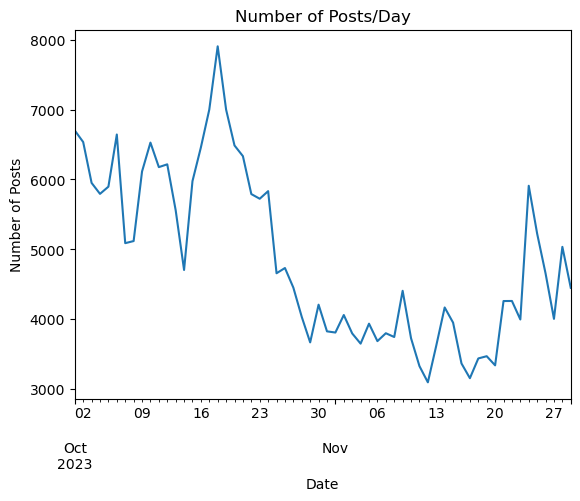

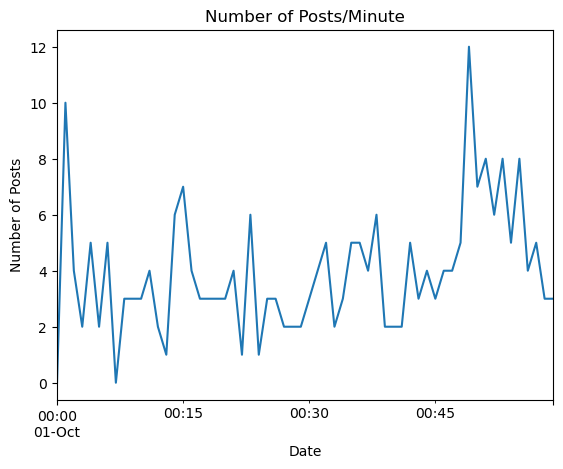

In [12]:
# Plot the number of posts and comments per day
sentiment_time_grouped.resample("D").row_count.sum().plot(kind="line")
plt.title("Number of Posts/Day")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.show()
# Plot the number of posts and comments per minute
sentiment_time_grouped.head(60).resample("1T").row_count.sum().plot(kind="line")
plt.title("Number of Posts/Minute")
plt.xlabel("Date")
plt.ylabel("Number of Posts")
plt.show()

In [13]:
"""
grid search for the optimal interval and return window size so that 
Granger causaulity test on the two time series is significant with p-value < 0.05 and lag = 1
"""


def plot_sentiment(posts_sorted, interval, sentiment_column="NET_sentiment"):
    plt.figure(figsize=(12, 8))
    plt.plot(posts_sorted["created"], posts_sorted[f"{sentiment_column}_{interval}"])
    plt.xlabel("Time")
    plt.ylabel("Net Sentiment Score")
    plt.title(f"Net Sentiment Score Dynamics for {interval.replace('T', ' min')}")
    # xlabel too long, rotate it
    plt.xticks(rotation=45)
    plt.show()


def plot_sentiment_and_close(posts_sorted, interval, df, sentiment_column="NET_sentiment"):
    plt.figure(figsize=(12, 8))
    # scale the net sentiment score to the same scale as the price
    plt.plot(posts_sorted["created"], posts_sorted[f"{sentiment_column}_{interval}"])
    plt.plot(df.index, df["Close"])
    plt.xlabel("Time")
    plt.ylabel("Net Sentiment Score")
    plt.title(
        f"Net Sentiment Score Dynamics for {interval.replace('T', ' min')} VS close price"
    )
    # xlabel too long, rotate it
    plt.xticks(rotation=45)
    plt.show()


def plot_sentiment_and_return(
        df_sentiment_scaled, interval, window_size, return_col_name, return_window_size,
        sentiment_column="NET_sentiment"
):
    plt.figure(figsize=(12, 8))
    # scale the net sentiment score to the same scale as 5 min return
    plt.plot(
        df_sentiment_scaled.index, df_sentiment_scaled[f"{sentiment_column}_{interval}"]
    )
    plt.plot(df_sentiment_scaled.index, df_sentiment_scaled[return_col_name])
    plt.xlabel("Time")
    plt.ylabel("Net Sentiment Score")
    plt.title(
        f"past {window_size} mins Net Sentiment VS future {return_window_size} mins return"
    )
    # xlabel too long, rotate it
    plt.xticks(rotation=45)
    plt.show()


def calculate_granger_causality(time_grouped, interval="1T", return_window_size=1, max_lag=1,
                                sentiment_column="NET_sentiment"):
    # 5, 10, 30 mins net sentiment score compare to close to close return
    # sum the sentiment scores of the texts posted in a time period of 5  bars
    window_size = int(interval.replace("T", ""))
    posts_sorted = time_grouped.copy()
    if interval != interval_min:
        posts_sorted[f"{sentiment_column}_{interval}"] = (
            time_grouped[f"{sentiment_column}_{interval_min}"].rolling(window_size).sum()
        )
    posts_sorted.reset_index(inplace=True)
    # Display the DataFrame to verify
    # print(posts_sorted.head())

    # plot the net sentiment score over time
    # plot_sentiment(posts_sorted, interval)

    # # plot the net sentiment score and close price over time
    # plot_sentiment_and_close(posts_sorted, interval,df)

    # calculate 5 min/return window return over time
    return_col_name = f"{return_window_size}min_return"
    # calculate 5 min return IN THE FUTURE
    price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)

    # fill the NaN return with 0
    price_df[return_col_name].fillna(0, inplace=True)
    # merge the two dataframes
    df_sentiment = pd.merge(
        price_df.sort_index(),
        posts_sorted[["created", f"{sentiment_column}_{interval}"]].sort_values(
            "created"
        ),
        left_index=True,
        right_on="created",
    )
    # set created to be the index of df_sentiment
    df_sentiment.set_index("created", inplace=True)
    # fill the NaN sentiment with 0
    df_sentiment[f"{sentiment_column}_{interval}"].fillna(0, inplace=True)

    # Create a MinMaxScaler
    scaler = MinMaxScaler()
    # Apply the scaling
    scaled_data = scaler.fit_transform(
        df_sentiment[[f"{sentiment_column}_{interval}", return_col_name]]
    )
    # combine df_sentiment.index and scaled_data into a dataframe
    df_sentiment_scaled = pd.DataFrame(
        scaled_data,
        index=df_sentiment.index,
        columns=[f"{sentiment_column}_{interval}", return_col_name],
    )

    ## validate scaling by inverse transform see if it matches the original data
    # inverse_data = scaler.inverse_transform(scaled_data)
    # df_sentiment_inverse = pd.DataFrame(inverse_data, index=df_sentiment.index,
    #                                    columns=[f"{sentiment_column}_{interval}", return_text])

    # plot the net sentiment score and 5 min return over time
    # plot_sentiment_and_return(df_sentiment_scaled, interval,window_size,return_col_name,return_window_size)

    # perfrom Granger causaulity test on the two time series
    # y/dependent variable needs to be the first column,
    # x/causal variable needs to be the second column
    y_x_cols = [return_col_name, f"{sentiment_column}_{interval}"]
    test_result = grangercausalitytests(
        df_sentiment_scaled[y_x_cols], maxlag=max_lag, verbose=True
    )
    # return Granger causaulity p-value for each lag in a dictionary
    granger_results = []
    for lag, result in test_result.items():
        granger_result = {}
        granger_result["lag"] = lag
        granger_result["p-value"] = result[0]["ssr_ftest"][1]

        granger_results.append(granger_result)
    return pd.DataFrame(granger_results)


def grid_search(time_grouped, inerval_upper_bound, return_window_size_upper_bound, max_lag,
                sentiment_column="NET_sentiment"):
    results = []
    interval_list = [f"{i}T" for i in range(1, inerval_upper_bound)]
    return_window_size_list = [i for i in range(1, return_window_size_upper_bound)]
    for interval in interval_list:
        for return_window_size in return_window_size_list:
            granger_result_df = calculate_granger_causality(time_grouped,
                                                            interval, return_window_size, max_lag=max_lag,
                                                            sentiment_column=sentiment_column
                                                            )
            for i, row in granger_result_df.iterrows():
                result = {}
                result["interval"] = interval
                result["return_window_size"] = return_window_size
                result["lag"] = row["lag"]
                result["ssr_ftest_p_value"] = row["p-value"]
                results.append(result)
    results_df = pd.DataFrame(results)
    return results_df


# plot the results_df with return_window_size as x-axis and interval as y-axis, ssr_ftest_p_value as z-axis
# Extract data for plotting
def get_filtered_df(results_df, significant_level):
    filtered_df = results_df[results_df["ssr_ftest_p_value"] < significant_level]
    x = filtered_df["return_window_size"]
    y = filtered_df["lag"]
    z = filtered_df["ssr_ftest_p_value"]
    return x, y, z


def plot_granger_result_confidence(results_df, significant_level):
    x, y, z = get_filtered_df(results_df, significant_level=significant_level)
    # plot the results_df with return_window_size as x-axis and interval as y-axis, ssr_ftest_p_value as color

    colors = z  # Color based on ssr_ftest_p_value

    # Create a scatter plot
    plt.scatter(x, y, c=colors, cmap="viridis")

    # Set labels
    plt.xlabel("Return Window Size")
    plt.ylabel("Lag")

    # Add a color bar to interpret the colors
    plt.colorbar(label="SSR F-test P-Value")

    # Show the plot
    plt.show()

    # Create a scatter plot
    plt.scatter(x, z, cmap="viridis")

    # Set labels
    plt.xlabel("Return Window Size")
    plt.ylabel("p-value")
    # Show the plot
    plt.show()


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4876  , p=0.4850  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.4876  , p=0.4850  , df=1
likelihood ratio test: chi2=0.4876  , p=0.4850  , df=1
parameter F test:         F=0.4876  , p=0.4850  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.2695  , p=0.7638  , df_denom=86153, df_num=2
ssr based chi2 test:   chi2=0.5390  , p=0.7638  , df=2
likelihood ratio test: chi2=0.5390  , p=0.7638  , df=2
parameter F test:         F=0.2695  , p=0.7638  , df_denom=86153, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2063  , p=0.8921  , df_denom=86150, df_num=3
ssr based chi2 test:   chi2=0.6188  , p=0.8921  , df=3
likelihood ratio test: chi2=0.6188  , p=0.8921  , df=3
parameter F test:         F=0.2063  , p=0.8921  , df_denom=86150, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.4506  

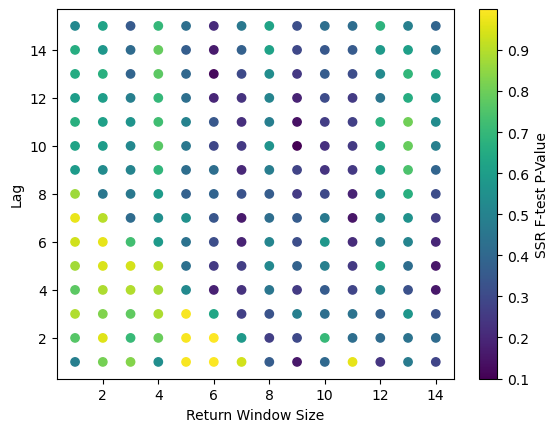

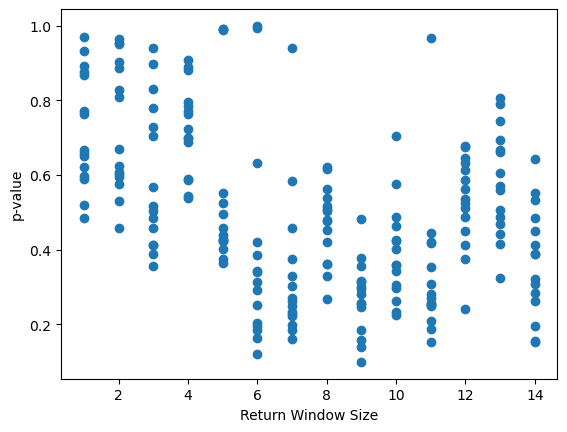

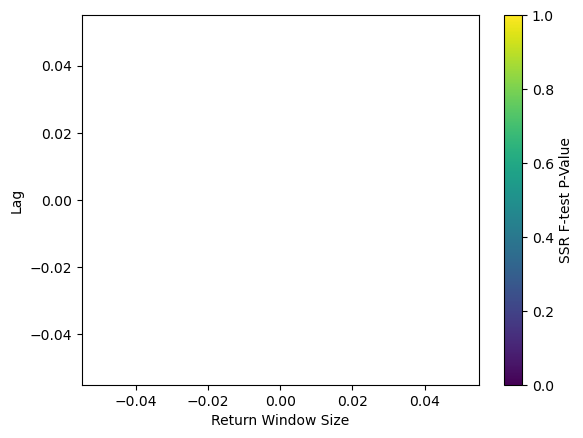

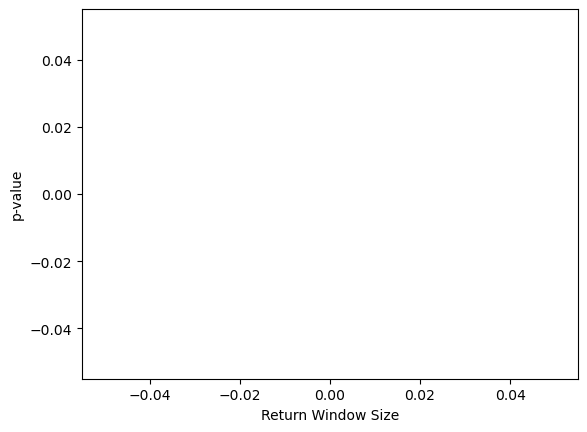

In [14]:
if not os.path.exists("df.pkl"):
    price_df = load_price_data(file_path="data/ETHUSD_min.csv")
else:
    price_df = pd.read_pickle("df.pkl")

sentiment_column = "NET_compound"
compound_results_df = grid_search(sentiment_time_grouped,
                                  inerval_upper_bound=2, return_window_size_upper_bound=15, max_lag=15,
                                  sentiment_column=sentiment_column
                                  )
plot_granger_result_confidence(compound_results_df, significant_level=1)
plot_granger_result_confidence(compound_results_df, significant_level=0.05)

# results_df2 = grid_search(
#     inerval_upper_bound=2, return_window_size_upper_bound=240, max_lag=1
# )
# plot_granger_result_confidence(results_df2, significant_level=0.05)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0962  , p=0.7564  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0962  , p=0.7564  , df=1
likelihood ratio test: chi2=0.0962  , p=0.7564  , df=1
parameter F test:         F=0.0962  , p=0.7564  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0488  , p=0.9523  , df_denom=86153, df_num=2
ssr based chi2 test:   chi2=0.0977  , p=0.9523  , df=2
likelihood ratio test: chi2=0.0977  , p=0.9523  , df=2
parameter F test:         F=0.0488  , p=0.9523  , df_denom=86153, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.0798  , p=0.9710  , df_denom=86150, df_num=3
ssr based chi2 test:   chi2=0.2396  , p=0.9710  , df=3
likelihood ratio test: chi2=0.2396  , p=0.9710  , df=3
parameter F test:         F=0.0798  , p=0.9710  , df_denom=86150, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.3907  

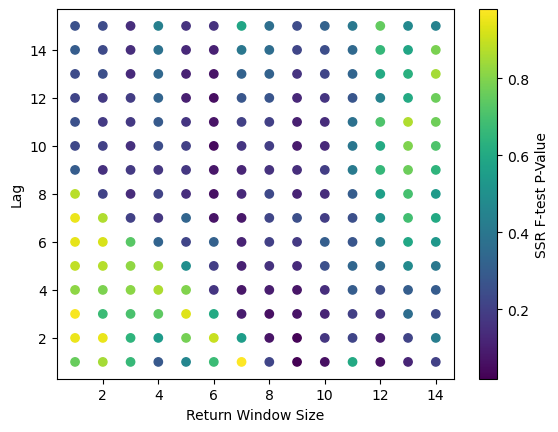

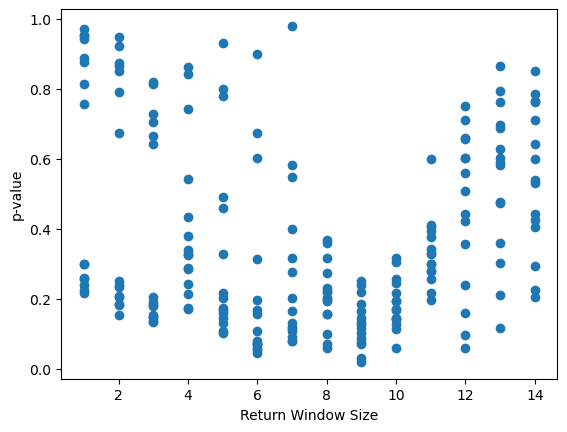

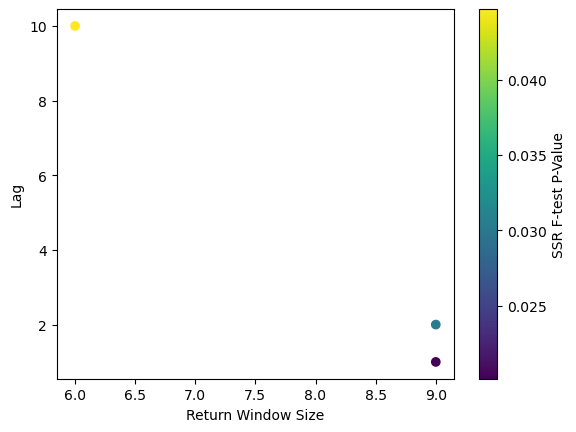

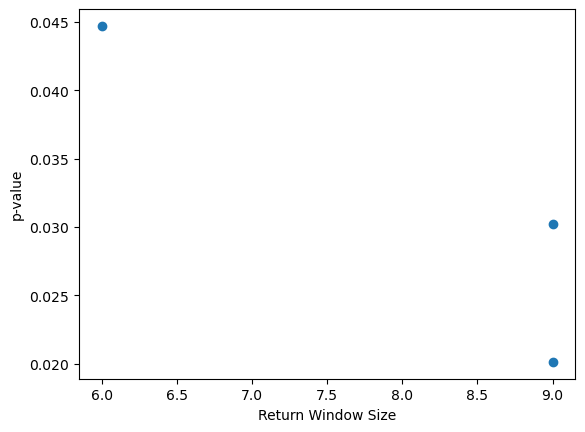


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0962  , p=0.7564  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0962  , p=0.7564  , df=1
likelihood ratio test: chi2=0.0962  , p=0.7564  , df=1
parameter F test:         F=0.0962  , p=0.7564  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0354  , p=0.8508  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0354  , p=0.8508  , df=1
likelihood ratio test: chi2=0.0354  , p=0.8508  , df=1
parameter F test:         F=0.0354  , p=0.8508  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1877  , p=0.6649  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1877  , p=0.6649  , df=1
likelihood ratio test: chi2=0.1877  , p=0.6649  , df=1
parameter F test:         F=0.1877  , p=0.6649  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1373  

<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8739  , p=0.1710  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.8740  , p=0.1710  , df=1
likelihood ratio test: chi2=1.8740  , p=0.1710  , df=1
parameter F test:         F=1.8739  , p=0.1710  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2938  , p=0.5878  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2938  , p=0.5878  , df=1
likelihood ratio test: chi2=0.2938  , p=0.5878  , df=1
parameter F test:         F=0.2938  , p=0.5878  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.7385  , p=0.0532  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.7386  , p=0.0532  , df=1
likelihood ratio test: chi2=3.7385  , p=0.0532  , df=1
parameter F test:         F=3.7385  , p=0.0532  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1465  

<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.8954  , p=0.0888  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.8955  , p=0.0888  , df=1
likelihood ratio test: chi2=2.8954  , p=0.0888  , df=1
parameter F test:         F=2.8954  , p=0.0888  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.2602  , p=0.0710  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.2603  , p=0.0710  , df=1
likelihood ratio test: chi2=3.2602  , p=0.0710  , df=1
parameter F test:         F=3.2602  , p=0.0710  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns 

ssr based F test:         F=2.1659  , p=0.1411  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.1659  , p=0.1411  , df=1
likelihood ratio test: chi2=2.1659  , p=0.1411  , df=1
parameter F test:         F=2.1659  , p=0.1411  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4188  , p=0.2336  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.4189  , p=0.2336  , df=1
likelihood ratio test: chi2=1.4189  , p=0.2336  , df=1
parameter F test:         F=1.4188  , p=0.2336  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.4715  , p=0.4923  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.4715  , p=0.4923  , df=1
likelihood ratio test: chi2=0.4715  , p=0.4923  , df=1
parameter F test:         F=0.4715  , p=0.4923  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9094  , p=0.3403  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.9095  , p=0.3403  , df=1
likelihood ratio test: chi2=0.9095  , p=0.3403  , df=1
parameter F test:         F=0.9094  , p=0.3403  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=1.6498  , p=0.1990  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.6499  , p=0.1990  , df=1
likelihood ratio test: chi2=1.6499  , p=0.1990  , df=1
parameter F test:         F=1.6498  , p=0.1990  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6771  , p=0.4106  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.6771  , p=0.4106  , df=1
likelihood ratio test: chi2=0.6771  , p=0.4106  , df=1
parameter F test:         F=0.6771  , p=0.4106  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.0156  , p=0.9005  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0156  , p=0.9005  , df=1
likelihood ratio test: chi2=0.0156  , p=0.9005  , df=1
parameter F test:         F=0.0156  , p=0.9005  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2754  , p=0.5998  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2754  , p=0.5997  , df=1
likelihood ratio test: chi2=0.2754  , p=0.5997  , df=1
parameter F test:         F=0.2754  , p=0.5998  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.0643  , p=0.7999  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0643  , p=0.7999  , df=1
likelihood ratio test: chi2=0.0643  , p=0.7999  , df=1
parameter F test:         F=0.0643  , p=0.7999  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3422  , p=0.2467  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.3422  , p=0.2466  , df=1
likelihood ratio test: chi2=1.3422  , p=0.2466  , df=1
parameter F test:         F=1.3422  , p=0.2467  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.0684  , p=0.7936  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0684  , p=0.7936  , df=1
likelihood ratio test: chi2=0.0684  , p=0.7936  , df=1
parameter F test:         F=0.0684  , p=0.7936  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4574  , p=0.2273  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.4575  , p=0.2273  , df=1
likelihood ratio test: chi2=1.4575  , p=0.2273  , df=1
parameter F test:         F=1.4574  , p=0.2273  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.1516  , p=0.6970  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1516  , p=0.6970  , df=1
likelihood ratio test: chi2=0.1516  , p=0.6970  , df=1
parameter F test:         F=0.1516  , p=0.6970  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3090  , p=0.5783  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3091  , p=0.5783  , df=1
likelihood ratio test: chi2=0.3091  , p=0.5783  , df=1
parameter F test:         F=0.3090  , p=0.5783  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.6927  , p=0.4052  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.6928  , p=0.4052  , df=1
likelihood ratio test: chi2=0.6928  , p=0.4052  , df=1
parameter F test:         F=0.6927  , p=0.4052  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3581  , p=0.5496  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3581  , p=0.5496  , df=1
likelihood ratio test: chi2=0.3581  , p=0.5496  , df=1
parameter F test:         F=0.3581  , p=0.5496  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=1.1498  , p=0.2836  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.1498  , p=0.2836  , df=1
likelihood ratio test: chi2=1.1498  , p=0.2836  , df=1
parameter F test:         F=1.1498  , p=0.2836  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0261  , p=0.8715  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0261  , p=0.8715  , df=1
likelihood ratio test: chi2=0.0261  , p=0.8715  , df=1
parameter F test:         F=0.0261  , p=0.8715  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.0128  , p=0.9098  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0128  , p=0.9098  , df=1
likelihood ratio test: chi2=0.0128  , p=0.9098  , df=1
parameter F test:         F=0.0128  , p=0.9098  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1188  , p=0.7304  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1188  , p=0.7304  , df=1
likelihood ratio test: chi2=0.1188  , p=0.7304  , df=1
parameter F test:         F=0.1188  , p=0.7304  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.9016  , p=0.3424  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.9016  , p=0.3424  , df=1
likelihood ratio test: chi2=0.9016  , p=0.3424  , df=1
parameter F test:         F=0.9016  , p=0.3424  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0034  , p=0.9537  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0034  , p=0.9537  , df=1
likelihood ratio test: chi2=0.0034  , p=0.9537  , df=1
parameter F test:         F=0.0034  , p=0.9537  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


ssr based F test:         F=0.8279  , p=0.3629  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.8279  , p=0.3629  , df=1
likelihood ratio test: chi2=0.8279  , p=0.3629  , df=1
parameter F test:         F=0.8279  , p=0.3629  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.9975  , p=0.3179  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.9976  , p=0.3179  , df=1
likelihood ratio test: chi2=0.9976  , p=0.3179  , df=1
parameter F test:         F=0.9975  , p=0.3179  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1914  , p=0.6617  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1914  , p=0.6617  , df=1
likelihood ratio test: chi2=0.1914  , p=0.6617  , df=1
parameter F test:         F=0.1914  , p=0.6617  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4624  , p=0.4965  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.4624  , p=0.4965  , df=1
likelihood ratio test: chi2=0.4624  , p=0.4965  , df=1
parameter F test:         F=0.4624  , p=0.4965  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4073  , p=0.5233  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.4073  , p=0.5233  , df=1
likelihood ratio test: chi2=0.4073  , p=0.5233  , df=1
parameter F test:         F=0.4073  , p=0.5233  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0027  , p=0.9587  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0027  , p=0.9587  , df=1
likelihood ratio test: chi2=0.0027  , p=0.9587  , df=1
parameter F test:         F=0.0027  , p=0.9587  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0334  , p=0.1539  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.0335  , p=0.1539  , df=1
likelihood ratio test: chi2=2.0335  , p=0.1539  , df=1
parameter F test:         F=2.0334  , p=0.1539  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0402  , p=0.8410  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0402  , p=0.8410  , df=1
likelihood ratio test: chi2=0.0402  , p=0.8410  , df=1
parameter F test:         F=0.0402  , p=0.8410  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.9089  , p=0.0480  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.9090  , p=0.0480  , df=1
likelihood ratio test: chi2=3.9089  , p=0.0480  , df=1
parameter F test:         F=3.9089  , p=0.0480  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0878  , p=0.7670  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0878  , p=0.7670  , df=1
likelihood ratio test: chi2=0.0878  , p=0.7670  , df=1
parameter F test:         F=0.0878  , p=0.7670  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.2341  , p=0.0222  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=5.2343  , p=0.0221  , df=1
likelihood ratio test: chi2=5.2341  , p=0.0221  , df=1
parameter F test:         F=5.2341  , p=0.0222  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6593  , p=0.1030  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.6594  , p=0.1029  , df=1
likelihood ratio test: chi2=2.6593  , p=0.1029  , df=1
parameter F test:         F=2.6593  , p=0.1030  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3443  , p=0.1257  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.3444  , p=0.1257  , df=1
likelihood ratio test: chi2=2.3443  , p=0.1257  , df=1
parameter F test:         F=2.3443  , p=0.1257  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8466  , p=0.3575  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.8467  , p=0.3575  , df=1
likelihood ratio test: chi2=0.8467  , p=0.3575  , df=1
parameter F test:         F=0.8466  , p=0.3575  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2336  , p=0.6289  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2336  , p=0.6289  , df=1
likelihood ratio test: chi2=0.2336  , p=0.6289  , df=1
parameter F test:         F=0.2336  , p=0.6289  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5279  , p=0.4675  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5279  , p=0.4675  , df=1
likelihood ratio test: chi2=0.5279  , p=0.4675  , df=1
parameter F test:         F=0.5279  , p=0.4675  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1399  , p=0.0764  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.1400  , p=0.0764  , df=1
likelihood ratio test: chi2=3.1399  , p=0.0764  , df=1
parameter F test:         F=3.1399  , p=0.0764  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3087  , p=0.5785  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3087  , p=0.5785  , df=1
likelihood ratio test: chi2=0.3087  , p=0.5785  , df=1
parameter F test:         F=0.3087  , p=0.5785  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5870  , p=0.4436  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5870  , p=0.4436  , df=1
likelihood ratio test: chi2=0.5870  , p=0.4436  , df=1
parameter F test:         F=0.5870  , p=0.4436  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9876  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9876  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9876  , df=1
parameter F test:         F=0.0002  , p=0.9876  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0866  , p=0.7685  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0866  , p=0.7685  , df=1
likelihood ratio test: chi2=0.0866  , p=0.7685  , df=1
parameter F test:         F=0.0866  , p=0.7685  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0440  , p=0.3069  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.0441  , p=0.3069  , df=1
likelihood ratio test: chi2=1.0441  , p=0.3069  , df=1
parameter F test:         F=1.0440  , p=0.3069  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0098  , p=0.9210  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0098  , p=0.9210  , df=1
likelihood ratio test: chi2=0.0098  , p=0.9210  , df=1
parameter F test:         F=0.0098  , p=0.9210  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8379  , p=0.3600  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.8379  , p=0.3600  , df=1
likelihood ratio test: chi2=0.8379  , p=0.3600  , df=1
parameter F test:         F=0.8379  , p=0.3600  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6986  , p=0.1004  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.6987  , p=0.1004  , df=1
likelihood ratio test: chi2=2.6987  , p=0.1004  , df=1
parameter F test:         F=2.6986  , p=0.1004  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0107  , p=0.9175  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0107  , p=0.9175  , df=1
likelihood ratio test: chi2=0.0107  , p=0.9175  , df=1
parameter F test:         F=0.0107  , p=0.9175  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8288  , p=0.1763  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.8289  , p=0.1763  , df=1
likelihood ratio test: chi2=1.8289  , p=0.1763  , df=1
parameter F test:         F=1.8288  , p=0.1763  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3556  , p=0.5509  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3556  , p=0.5509  , df=1
likelihood ratio test: chi2=0.3556  , p=0.5509  , df=1
parameter F test:         F=0.3556  , p=0.5509  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3591  , p=0.5490  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3592  , p=0.5490  , df=1
likelihood ratio test: chi2=0.3592  , p=0.5490  , df=1
parameter F test:         F=0.3591  , p=0.5490  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5147  , p=0.4731  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5147  , p=0.4731  , df=1
likelihood ratio test: chi2=0.5147  , p=0.4731  , df=1
parameter F test:         F=0.5147  , p=0.4731  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.3630  , p=0.0667  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.3631  , p=0.0667  , df=1
likelihood ratio test: chi2=3.3631  , p=0.0667  , df=1
parameter F test:         F=3.3630  , p=0.0667  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5114  , p=0.4745  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5115  , p=0.4745  , df=1
likelihood ratio test: chi2=0.5115  , p=0.4745  , df=1
parameter F test:         F=0.5114  , p=0.4745  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6193  , p=0.0058  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=7.6195  , p=0.0058  , df=1
likelihood ratio test: chi2=7.6192  , p=0.0058  , df=1
parameter F test:         F=7.6193  , p=0.0058  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6522  , p=0.1987  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.6522  , p=0.1987  , df=1
likelihood ratio test: chi2=1.6522  , p=0.1987  , df=1
parameter F test:         F=1.6522  , p=0.1987  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.6149  , p=0.0058  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=7.6151  , p=0.0058  , df=1
likelihood ratio test: chi2=7.6148  , p=0.0058  , df=1
parameter F test:         F=7.6149  , p=0.0058  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7358  , p=0.3910  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7359  , p=0.3910  , df=1
likelihood ratio test: chi2=0.7358  , p=0.3910  , df=1
parameter F test:         F=0.7358  , p=0.3910  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.7753  , p=0.0957  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.7754  , p=0.0957  , df=1
likelihood ratio test: chi2=2.7753  , p=0.0957  , df=1
parameter F test:         F=2.7753  , p=0.0957  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7108  , p=0.3992  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7109  , p=0.3992  , df=1
likelihood ratio test: chi2=0.7109  , p=0.3992  , df=1
parameter F test:         F=0.7108  , p=0.3992  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0018  , p=0.1571  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.0018  , p=0.1571  , df=1
likelihood ratio test: chi2=2.0018  , p=0.1571  , df=1
parameter F test:         F=2.0018  , p=0.1571  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3938  , p=0.0361  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=4.3939  , p=0.0361  , df=1
likelihood ratio test: chi2=4.3938  , p=0.0361  , df=1
parameter F test:         F=4.3938  , p=0.0361  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.2775  , p=0.0122  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=6.2777  , p=0.0122  , df=1
likelihood ratio test: chi2=6.2775  , p=0.0122  , df=1
parameter F test:         F=6.2775  , p=0.0122  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7708  , p=0.3800  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7708  , p=0.3800  , df=1
likelihood ratio test: chi2=0.7708  , p=0.3800  , df=1
parameter F test:         F=0.7708  , p=0.3800  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9878  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9878  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9878  , df=1
parameter F test:         F=0.0002  , p=0.9878  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0910  , p=0.7629  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0910  , p=0.7629  , df=1
likelihood ratio test: chi2=0.0910  , p=0.7629  , df=1
parameter F test:         F=0.0910  , p=0.7629  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.4780  , p=0.2241  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.4780  , p=0.2241  , df=1
likelihood ratio test: chi2=1.4780  , p=0.2241  , df=1
parameter F test:         F=1.4780  , p=0.2241  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1761  , p=0.1402  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.1762  , p=0.1402  , df=1
likelihood ratio test: chi2=2.1762  , p=0.1402  , df=1
parameter F test:         F=2.1761  , p=0.1402  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3499  , p=0.2453  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.3499  , p=0.2453  , df=1
likelihood ratio test: chi2=1.3499  , p=0.2453  , df=1
parameter F test:         F=1.3499  , p=0.2453  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2588  , p=0.6109  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2588  , p=0.6109  , df=1
likelihood ratio test: chi2=0.2588  , p=0.6109  , df=1
parameter F test:         F=0.2588  , p=0.6109  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0912  , p=0.1481  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.0913  , p=0.1481  , df=1
likelihood ratio test: chi2=2.0913  , p=0.1481  , df=1
parameter F test:         F=2.0912  , p=0.1481  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.4762  , p=0.4902  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.4762  , p=0.4901  , df=1
likelihood ratio test: chi2=0.4762  , p=0.4901  , df=1
parameter F test:         F=0.4762  , p=0.4902  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6747  , p=0.4114  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.6748  , p=0.4114  , df=1
likelihood ratio test: chi2=0.6748  , p=0.4114  , df=1
parameter F test:         F=0.6747  , p=0.4114  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.0341  , p=0.1538  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.0342  , p=0.1538  , df=1
likelihood ratio test: chi2=2.0342  , p=0.1538  , df=1
parameter F test:         F=2.0341  , p=0.1538  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2345  , p=0.1350  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.2346  , p=0.1350  , df=1
likelihood ratio test: chi2=2.2346  , p=0.1350  , df=1
parameter F test:         F=2.2345  , p=0.1350  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1880  , p=0.6646  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1880  , p=0.6646  , df=1
likelihood ratio test: chi2=0.1880  , p=0.6646  , df=1
parameter F test:         F=0.1880  , p=0.6646  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1490  , p=0.2838  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.1490  , p=0.2838  , df=1
likelihood ratio test: chi2=1.1490  , p=0.2838  , df=1
parameter F test:         F=1.1490  , p=0.2838  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7970  , p=0.3720  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7970  , p=0.3720  , df=1
likelihood ratio test: chi2=0.7970  , p=0.3720  , df=1
parameter F test:         F=0.7970  , p=0.3720  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2987  , p=0.1295  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.2988  , p=0.1295  , df=1
likelihood ratio test: chi2=2.2988  , p=0.1295  , df=1
parameter F test:         F=2.2987  , p=0.1295  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0706  , p=0.7905  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0706  , p=0.7905  , df=1
likelihood ratio test: chi2=0.0706  , p=0.7905  , df=1
parameter F test:         F=0.0706  , p=0.7905  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0776  , p=0.7806  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0776  , p=0.7806  , df=1
likelihood ratio test: chi2=0.0776  , p=0.7806  , df=1
parameter F test:         F=0.0776  , p=0.7806  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.5870  , p=0.0582  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.5871  , p=0.0582  , df=1
likelihood ratio test: chi2=3.5870  , p=0.0582  , df=1
parameter F test:         F=3.5870  , p=0.0582  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=3.1380  , p=0.0765  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=3.1381  , p=0.0765  , df=1
likelihood ratio test: chi2=3.1381  , p=0.0765  , df=1
parameter F test:         F=3.1380  , p=0.0765  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2728  , p=0.6014  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2728  , p=0.6014  , df=1
likelihood ratio test: chi2=0.2728  , p=0.6014  , df=1
parameter F test:         F=0.2728  , p=0.6014  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0336  , p=0.8546  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0336  , p=0.8546  , df=1
likelihood ratio test: chi2=0.0336  , p=0.8546  , df=1
parameter F test:         F=0.0336  , p=0.8546  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7546  , p=0.1853  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.7546  , p=0.1853  , df=1
likelihood ratio test: chi2=1.7546  , p=0.1853  , df=1
parameter F test:         F=1.7546  , p=0.1853  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5239  , p=0.4692  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5239  , p=0.4692  , df=1
likelihood ratio test: chi2=0.5239  , p=0.4692  , df=1
parameter F test:         F=0.5239  , p=0.4692  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8387  , p=0.3598  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.8388  , p=0.3598  , df=1
likelihood ratio test: chi2=0.8388  , p=0.3598  , df=1
parameter F test:         F=0.8387  , p=0.3598  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7947  , p=0.3727  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7947  , p=0.3727  , df=1
likelihood ratio test: chi2=0.7947  , p=0.3727  , df=1
parameter F test:         F=0.7947  , p=0.3727  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7452  , p=0.3880  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7453  , p=0.3880  , df=1
likelihood ratio test: chi2=0.7453  , p=0.3880  , df=1
parameter F test:         F=0.7452  , p=0.3880  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1438  , p=0.7045  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1439  , p=0.7045  , df=1
likelihood ratio test: chi2=0.1439  , p=0.7045  , df=1
parameter F test:         F=0.1438  , p=0.7045  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1761  , p=0.2782  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.1761  , p=0.2782  , df=1
likelihood ratio test: chi2=1.1761  , p=0.2782  , df=1
parameter F test:         F=1.1761  , p=0.2782  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2798  , p=0.5969  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2798  , p=0.5968  , df=1
likelihood ratio test: chi2=0.2798  , p=0.5968  , df=1
parameter F test:         F=0.2798  , p=0.5969  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5233  , p=0.4695  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5233  , p=0.4695  , df=1
likelihood ratio test: chi2=0.5233  , p=0.4695  , df=1
parameter F test:         F=0.5233  , p=0.4695  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0002  , p=0.9892  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0002  , p=0.9892  , df=1
likelihood ratio test: chi2=0.0002  , p=0.9892  , df=1
parameter F test:         F=0.0002  , p=0.9892  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3649  , p=0.5458  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3649  , p=0.5458  , df=1
likelihood ratio test: chi2=0.3649  , p=0.5458  , df=1
parameter F test:         F=0.3649  , p=0.5458  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.6172  , p=0.1057  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.6173  , p=0.1057  , df=1
likelihood ratio test: chi2=2.6172  , p=0.1057  , df=1
parameter F test:         F=2.6172  , p=0.1057  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=4.3405  , p=0.0372  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=4.3406  , p=0.0372  , df=1
likelihood ratio test: chi2=4.3405  , p=0.0372  , df=1
parameter F test:         F=4.3405  , p=0.0372  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2039  , p=0.1377  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.2040  , p=0.1377  , df=1
likelihood ratio test: chi2=2.2040  , p=0.1377  , df=1
parameter F test:         F=2.2039  , p=0.1377  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0057  , p=0.9398  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0057  , p=0.9398  , df=1
likelihood ratio test: chi2=0.0057  , p=0.9398  , df=1
parameter F test:         F=0.0057  , p=0.9398  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0880  , p=0.7668  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0880  , p=0.7668  , df=1
likelihood ratio test: chi2=0.0880  , p=0.7668  , df=1
parameter F test:         F=0.0880  , p=0.7668  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=5.6243  , p=0.0177  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=5.6245  , p=0.0177  , df=1
likelihood ratio test: chi2=5.6243  , p=0.0177  , df=1
parameter F test:         F=5.6243  , p=0.0177  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0940  , p=0.7592  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0940  , p=0.7592  , df=1
likelihood ratio test: chi2=0.0940  , p=0.7592  , df=1
parameter F test:         F=0.0940  , p=0.7592  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0041  , p=0.3163  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.0042  , p=0.3163  , df=1
likelihood ratio test: chi2=1.0042  , p=0.3163  , df=1
parameter F test:         F=1.0041  , p=0.3163  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0126  , p=0.9108  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0126  , p=0.9108  , df=1
likelihood ratio test: chi2=0.0126  , p=0.9108  , df=1
parameter F test:         F=0.0126  , p=0.9108  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5820  , p=0.2085  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.5821  , p=0.2085  , df=1
likelihood ratio test: chi2=1.5821  , p=0.2085  , df=1
parameter F test:         F=1.5820  , p=0.2085  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0562  , p=0.8125  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0563  , p=0.8125  , df=1
likelihood ratio test: chi2=0.0563  , p=0.8125  , df=1
parameter F test:         F=0.0562  , p=0.8125  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3644  , p=0.5461  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3644  , p=0.5461  , df=1
likelihood ratio test: chi2=0.3644  , p=0.5461  , df=1
parameter F test:         F=0.3644  , p=0.5461  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6376  , p=0.2007  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.6377  , p=0.2006  , df=1
likelihood ratio test: chi2=1.6377  , p=0.2006  , df=1
parameter F test:         F=1.6376  , p=0.2007  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.6342  , p=0.2011  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.6342  , p=0.2011  , df=1
likelihood ratio test: chi2=1.6342  , p=0.2011  , df=1
parameter F test:         F=1.6342  , p=0.2011  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2647  , p=0.6069  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2647  , p=0.6069  , df=1
likelihood ratio test: chi2=0.2647  , p=0.6069  , df=1
parameter F test:         F=0.2647  , p=0.6069  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6026  , p=0.4376  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.6026  , p=0.4376  , df=1
likelihood ratio test: chi2=0.6026  , p=0.4376  , df=1
parameter F test:         F=0.6026  , p=0.4376  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2402  , p=0.6241  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2402  , p=0.6241  , df=1
likelihood ratio test: chi2=0.2402  , p=0.6241  , df=1
parameter F test:         F=0.2402  , p=0.6241  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.7387  , p=0.1873  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.7387  , p=0.1873  , df=1
likelihood ratio test: chi2=1.7387  , p=0.1873  , df=1
parameter F test:         F=1.7387  , p=0.1873  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.2046  , p=0.6510  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.2046  , p=0.6510  , df=1
likelihood ratio test: chi2=0.2046  , p=0.6510  , df=1
parameter F test:         F=0.2046  , p=0.6510  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.8976  , p=0.3434  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.8976  , p=0.3434  , df=1
likelihood ratio test: chi2=0.8976  , p=0.3434  , df=1
parameter F test:         F=0.8976  , p=0.3434  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=7.5293  , p=0.0061  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=7.5295  , p=0.0061  , df=1
likelihood ratio test: chi2=7.5292  , p=0.0061  , df=1
parameter F test:         F=7.5293  , p=0.0061  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.8679  , p=0.1717  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.8680  , p=0.1717  , df=1
likelihood ratio test: chi2=1.8679  , p=0.1717  , df=1
parameter F test:         F=1.8679  , p=0.1717  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1242  , p=0.7245  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.1242  , p=0.7245  , df=1
likelihood ratio test: chi2=0.1242  , p=0.7245  , df=1
parameter F test:         F=0.1242  , p=0.7245  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.3644  , p=0.5461  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.3644  , p=0.5461  , df=1
likelihood ratio test: chi2=0.3644  , p=0.5461  , df=1
parameter F test:         F=0.3644  , p=0.5461  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.7209  , p=0.3959  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.7209  , p=0.3958  , df=1
likelihood ratio test: chi2=0.7209  , p=0.3958  , df=1
parameter F test:         F=0.7209  , p=0.3959  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.3071  , p=0.1288  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.3072  , p=0.1288  , df=1
likelihood ratio test: chi2=2.3072  , p=0.1288  , df=1
parameter F test:         F=2.3071  , p=0.1288  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.5436  , p=0.2141  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.5437  , p=0.2141  , df=1
likelihood ratio test: chi2=1.5437  , p=0.2141  , df=1
parameter F test:         F=1.5436  , p=0.2141  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0580  , p=0.8096  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0580  , p=0.8096  , df=1
likelihood ratio test: chi2=0.0580  , p=0.8096  , df=1
parameter F test:         F=0.0580  , p=0.8096  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6688  , p=0.4135  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.6688  , p=0.4135  , df=1
likelihood ratio test: chi2=0.6688  , p=0.4135  , df=1
parameter F test:         F=0.6688  , p=0.4135  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0259  , p=0.8722  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0259  , p=0.8722  , df=1
likelihood ratio test: chi2=0.0259  , p=0.8722  , df=1
parameter F test:         F=0.0259  , p=0.8722  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5845  , p=0.4446  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.5845  , p=0.4446  , df=1
likelihood ratio test: chi2=0.5845  , p=0.4446  , df=1
parameter F test:         F=0.5845  , p=0.4446  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.1825  , p=0.1396  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.1826  , p=0.1396  , df=1
likelihood ratio test: chi2=2.1826  , p=0.1396  , df=1
parameter F test:         F=2.1825  , p=0.1396  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=2.2012  , p=0.1379  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=2.2013  , p=0.1379  , df=1
likelihood ratio test: chi2=2.2013  , p=0.1379  , df=1
parameter F test:         F=2.2012  , p=0.1379  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.1794  , p=0.2775  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.1795  , p=0.2775  , df=1
likelihood ratio test: chi2=1.1794  , p=0.2775  , df=1
parameter F test:         F=1.1794  , p=0.2775  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.6653  , p=0.4147  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.6653  , p=0.4147  , df=1
likelihood ratio test: chi2=0.6653  , p=0.4147  , df=1
parameter F test:         F=0.6653  , p=0.4147  , df_denom=86156, df_num=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)
<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)



Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.3182  , p=0.2509  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=1.3183  , p=0.2509  , df=1
likelihood ratio test: chi2=1.3183  , p=0.2509  , df=1
parameter F test:         F=1.3182  , p=0.2509  , df_denom=86156, df_num=1

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.0001  , p=0.9907  , df_denom=86156, df_num=1
ssr based chi2 test:   chi2=0.0001  , p=0.9907  , df=1
likelihood ratio test: chi2=0.0001  , p=0.9907  , df=1


<ipython-input-13-41aeaf4ff759>:77: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  price_df[return_col_name] = -price_df["Close"].pct_change(-return_window_size)


parameter F test:         F=0.0001  , p=0.9907  , df_denom=86156, df_num=1


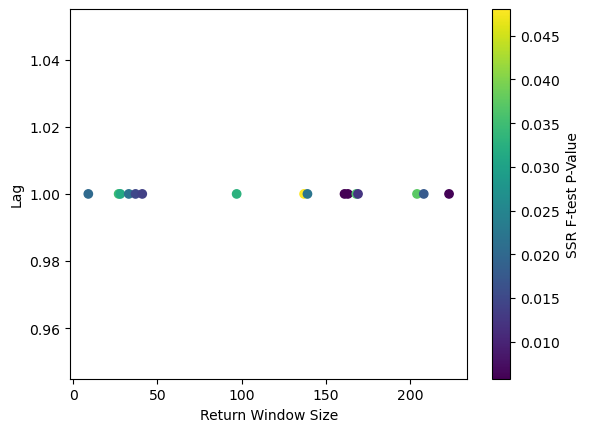

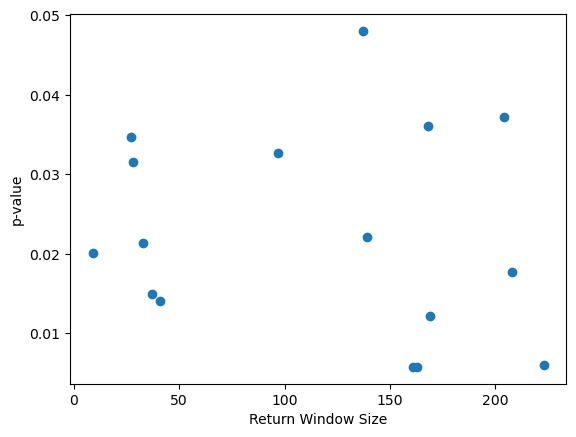

In [15]:
sentiment_column = "NET_sentiment"
net_results_df = grid_search(sentiment_time_grouped,
                             inerval_upper_bound=2, return_window_size_upper_bound=15, max_lag=15,
                             sentiment_column=sentiment_column
                             )
plot_granger_result_confidence(net_results_df, significant_level=1)
plot_granger_result_confidence(net_results_df, significant_level=0.05)

net_results_df2 = grid_search(sentiment_time_grouped,
                              inerval_upper_bound=2, return_window_size_upper_bound=240, max_lag=1
                              )
plot_granger_result_confidence(net_results_df2, significant_level=0.05)

sentiment_adfuller_p: 0.0
return_adfuller_p for 9 mins: 0.0
return_adfuller_p for 27 mins: 0.0
return_adfuller_p for 28 mins: 0.0
return_adfuller_p for 33 mins: 0.0
return_adfuller_p for 37 mins: 0.0
return_adfuller_p for 41 mins: 0.0
return_adfuller_p for 97 mins: 0.0
return_adfuller_p for 137 mins: 0.0
return_adfuller_p for 139 mins: 0.0
return_adfuller_p for 161 mins: 2.0337716442126566e-30
return_adfuller_p for 163 mins: 2.056230025727486e-30
return_adfuller_p for 168 mins: 2.6846465278281825e-30
return_adfuller_p for 169 mins: 3.475109091214457e-30
return_adfuller_p for 204 mins: 4.1857458154068395e-29
return_adfuller_p for 208 mins: 5.063537489473603e-29
return_adfuller_p for 223 mins: 2.5830073220542003e-28


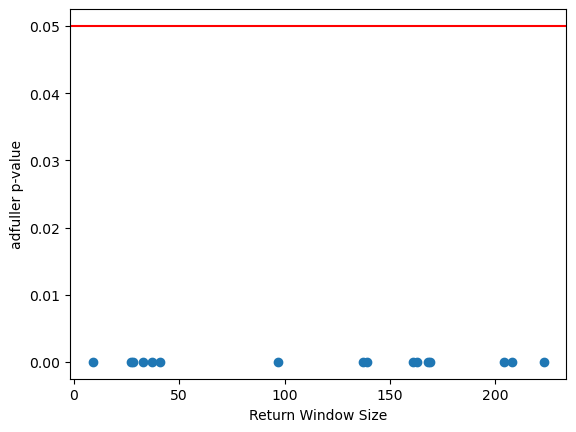

In [16]:
def check_adfuller_p():
    sentiment_adfuller_p = adfuller(sentiment_time_grouped[f"NET_sentiment_1T"])[1]
    print(f"sentiment_adfuller_p: {sentiment_adfuller_p}")
    # from net_results_df2, get the returns horizons  with the p-value < 0.05
    return_window_sizes,_,_ = get_filtered_df(net_results_df2, significant_level=0.05)
    return_adfuller_ps= []
    for return_window_size in return_window_sizes:
        return_col_name = f"{return_window_size}min_return"
        return_adfuller_p = adfuller(price_df[return_col_name])[1]
        return_adfuller_ps.append(return_adfuller_p)
        print(f"return_adfuller_p for {return_window_size} mins: {return_adfuller_p}")
    # plot scatter chart of return_window_size vs return_adfuller_ps
    plt.scatter(return_window_sizes, return_adfuller_ps)
    plt.xlabel("Return Window Size")
    plt.ylabel("adfuller p-value")
    # add a horizontal line at y = 0.05
    plt.axhline(y=0.05, color='r', linestyle='-')
    plt.show()


check_adfuller_p()